## Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization


## Load Data


In [2]:
high_altitude = pd.read_csv("./data/measurements-high-altitude.csv")
low_altitude = pd.read_csv("./data/measurements-low-altitude.csv")


## Data cleanup


In [3]:
list(high_altitude)

['hour',
 ' minute',
 ' second',
 ' azimuth angle (relative to west=0)/degree',
 ' elevation angle/degree',
 ' power/mW']

In [4]:
high_altitude.rename(columns={" power/mW": "power", " azimuth angle (relative to west=0)/degree": "azimuth", " elevation angle/degree": "elevation"}, inplace=True)
high_altitude.columns = high_altitude.columns.str.replace(" ", "")

low_altitude.rename(columns={" power/mW": "power", " azimuth angle (relative to west=0)/degree": "azimuth", " elevation angle/degree": "elevation"}, inplace=True)
low_altitude.columns = low_altitude.columns.str.replace(" ", "")

In [5]:
high_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,9,45,5,0,0,32
1,9,45,9,0,15,879
2,9,45,12,0,30,34
3,9,45,15,0,45,35
4,9,45,18,0,60,51


In [6]:
low_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,10,38,3,0,0,56
1,10,38,7,0,15,57
2,10,38,10,0,30,59
3,10,38,14,0,45,57
4,10,38,16,0,60,83


In [ ]:
high_altitude.describe()

In [7]:
high_altitude.loc[high_altitude.power.idxmax(), :]

hour            9
minute         45
second         38
azimuth        18
elevation      45
power        4168
Name: 10, dtype: int64

In [8]:
low_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000
mean,11.880294,30.643139,29.224732,90.000000,45.000000,279.383399
std,1.090955,18.001482,17.335092,56.937075,30.008473,82.632597
min,10.000000,0.000000,0.000000,0.000000,0.000000,41.000000
25%,11.000000,14.000000,14.000000,36.000000,15.000000,225.000000
50%,12.000000,32.000000,29.000000,90.000000,45.000000,302.000000
75%,13.000000,47.000000,44.000000,144.000000,75.000000,352.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,378.000000


### Convert index in datetime


In [9]:
df = high_altitude.loc[:, ["hour", "minute", "second"]]
l = len(high_altitude)
df["year"] = [2016] * l
df["month"] = [11] * l
df["day"] = [23] * l

high_altitude = high_altitude.set_index(pd.to_datetime(df))
high_altitude.head()

,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:09,9,45,9,0,15,879
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51


In [10]:
df = low_altitude.loc[:, ["hour", "minute", "second"]]
l = len(low_altitude)
df["year"] = [2016] * l
df["month"] = [11] * l
df["day"] = [23] * l

low_altitude = low_altitude.set_index(pd.to_datetime(df))
low_altitude.head()

,hour,minute,second,azimuth,elevation,power
2016-11-23 10:38:03,10,38,3,0,0,56
2016-11-23 10:38:07,10,38,7,0,15,57
2016-11-23 10:38:10,10,38,10,0,30,59
2016-11-23 10:38:14,10,38,14,0,45,57
2016-11-23 10:38:16,10,38,16,0,60,83


### Remove outliers from high_altitude


In [11]:
print(high_altitude.shape)
high_altitude = high_altitude[(np.abs(stats.zscore(high_altitude)) < 3).all(axis=1)]
print(high_altitude.shape)
high_altitude

(2469, 6)
(2459, 6)


,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51
2016-11-23 09:45:21,9,45,21,0,75,76
...,...,...,...,...,...,...
2016-11-23 14:46:27,14,46,27,36,90,172
2016-11-23 14:46:30,14,46,30,54,0,108
2016-11-23 14:46:35,14,46,35,54,15,159
2016-11-23 14:46:38,14,46,38,54,30,213


### Plots


<AxesSubplot:title={'center':'High Altitude Peak Power Measurements'}>

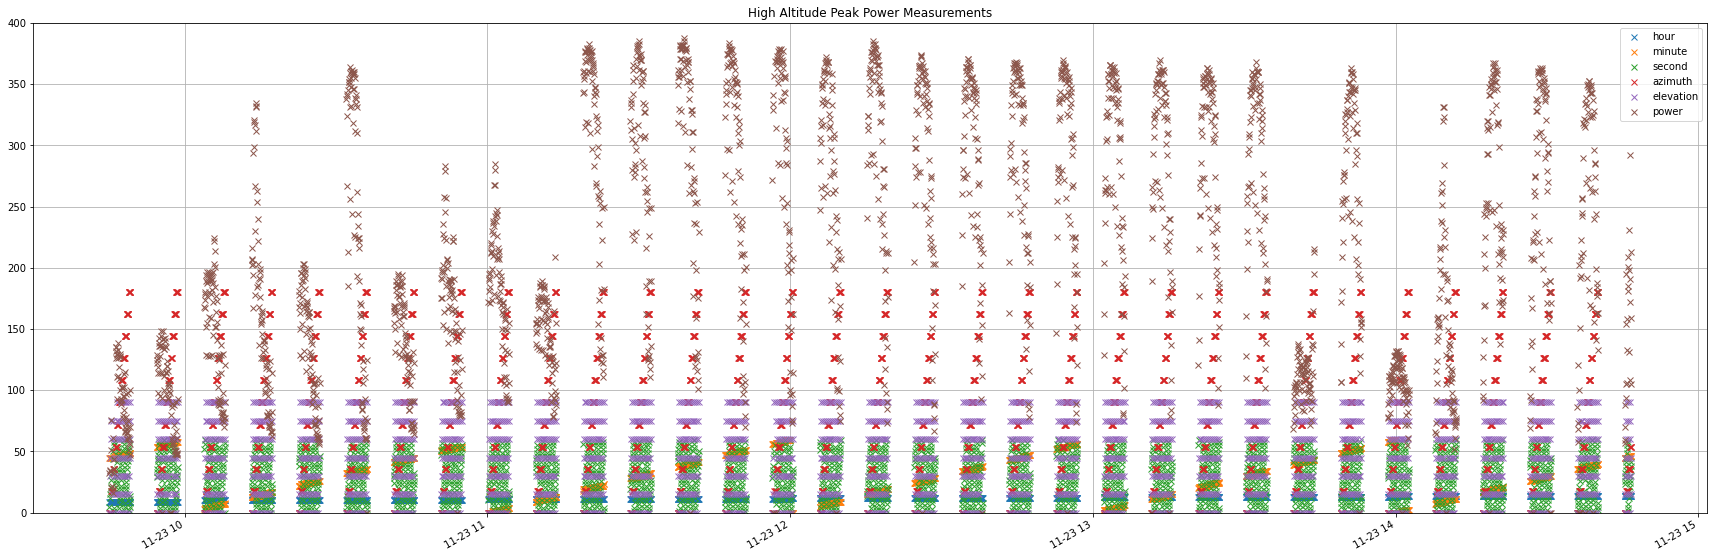

In [12]:
high_altitude.plot(figsize=(30, 10), title="High Altitude Peak Power Measurements", grid=True, marker="x", markersize=6, linestyle="None", ylim=(0, 400))

<AxesSubplot:title={'center':'Low Altitude Peak Power Measurements'}>

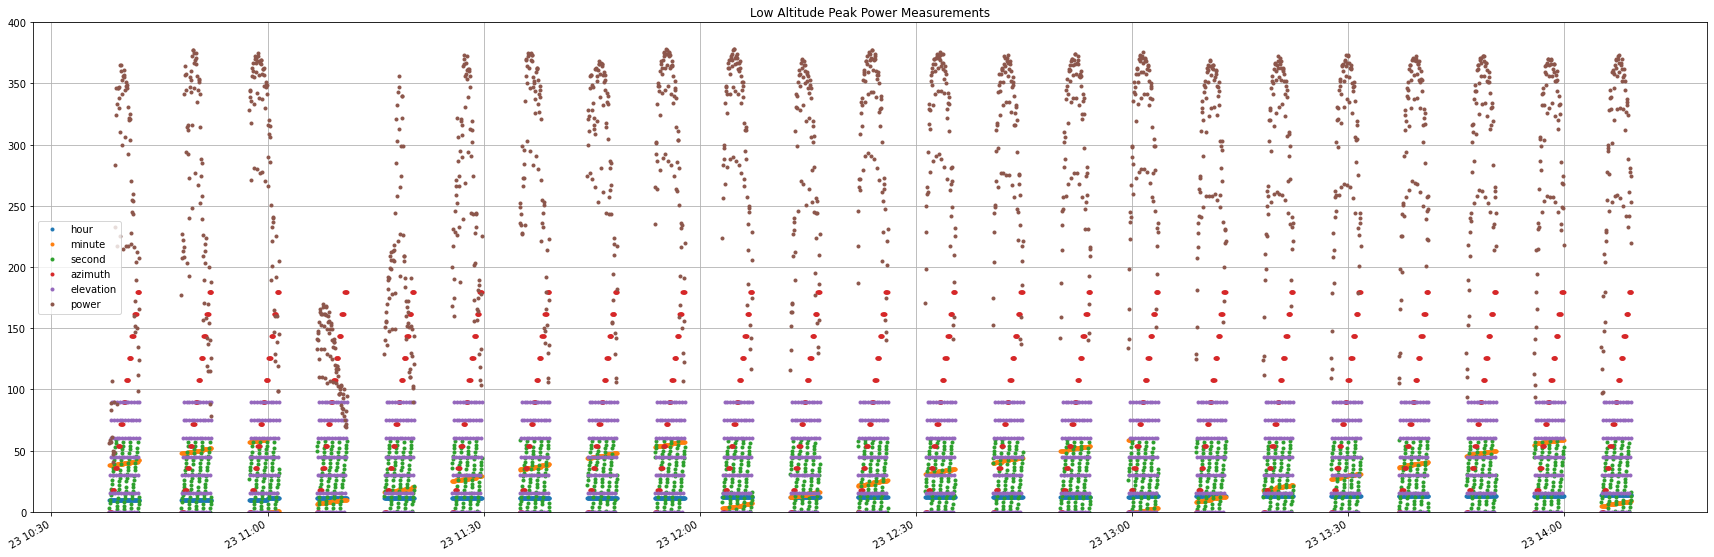

In [13]:
low_altitude.plot(figsize=(30, 10), title="Low Altitude Peak Power Measurements", grid=True, marker=".", markersize=6, linestyle="None", ylim=(0, 400))

## Regression using MLP


## Train test split


In [14]:
X_low_train = low_altitude.sample(frac=0.8, random_state=2)
X_low_test = low_altitude.drop(X_low_train.index)

y_low_train = X_low_train.pop("power")
y_low_test = X_low_test.pop("power")

print(y_low_train.describe())

count    1417.000000
mean      279.540579
std        82.386542
min        49.000000
25%       227.000000
50%       301.000000
75%       351.000000
max       378.000000
Name: power, dtype: float64


In [15]:
X_high_train = high_altitude.sample(frac=0.8, random_state=2)
X_high_test = high_altitude.drop(X_high_train.index)

y_high_train = X_high_train.pop("power")
y_high_test = X_high_test.pop("power")

print(y_high_train.describe())


count    1967.000000
mean      224.564311
std       104.227067
min         0.000000
25%       129.000000
50%       216.000000
75%       333.000000
max       388.000000
Name: power, dtype: float64


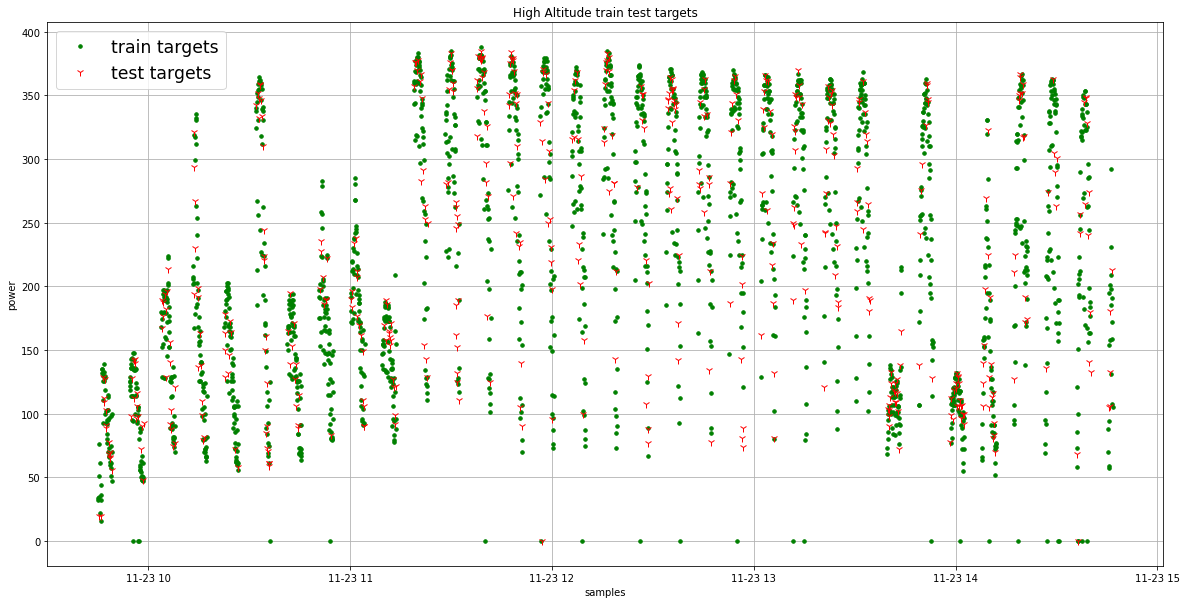

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(y_high_train, marker=".", color="g", linestyle="None", markersize=7, label="train targets")
plt.plot(y_high_test, marker="1", color="r", linestyle="None", markersize=7, label="test targets")
plt.title("High Altitude train test targets")
plt.xlabel("samples")
plt.ylabel("power")
plt.legend(fontsize="xx-large")
plt.grid()


### Normalization


In [17]:
normalizer_low = Normalization(axis=-1)
normalizer_low.adapt(np.array(X_low_train))

print("Normalizer low mean:", normalizer_low.mean.numpy())

2022-07-18 16:59:33.068260: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 16:59:33.068684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-18 16:59:33.125766: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-18 16:59:33.211857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 16:59:33.224943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Normalizer low mean: [[11.871558 30.616798 29.044462 88.81864  45.719826]]


In [18]:
first_sample = np.array(X_low_train[:1])

with np.printoptions(precision=2, suppress=True):
    print("X_low_train first sample:", np.sort(first_sample))
    print("X_low train first sample normalized:", np.sort(normalizer_low(first_sample).numpy()))


X_low_train first sample: [[ 0 11 15 26 44]]
X_low train first sample normalized: [[-1.56 -1.02 -0.8  -0.18  0.74]]


### Regressor

In [19]:
def create_regressor(normalizer):
    reg = Sequential(
        [
            normalizer,
            Dense(units=256, activation="relu"),
            Dropout(0.3),
            Dense(units=128, activation="relu"),
            Dense(units=1),
        ]
    )
    return reg

### Metrics

In [20]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-10, verbose=1), tf.keras.callbacks.EarlyStopping(patience=30)]
metrics = [tf.keras.metrics.MeanSquaredError()]

In [21]:
def plot_metrics(history, title: str = ''):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(20, 10)
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_title("loss (MAE)")
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("error")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history["mean_squared_error"], label="mse")
    ax2.plot(history.history["val_mean_squared_error"], label="val_mse")
    ax2.set_title("metric (MSE)")
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("error")
    ax2.legend()
    ax2.grid(True)

### Regression on Low Altitude


In [22]:
reg_low = create_regressor(normalizer_low)
reg_low.summary()
reg_low.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mae", metrics=metrics)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1536      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,572
Trainable params: 34,561
Non-trainable params: 11
___________________________________________________

In [23]:
history = reg_low.fit(X_low_train, y_low_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
 1/36 [..............................] - ETA: 9s - loss: 279.3448 - mean_squared_error: 82876.0547

2022-07-18 16:59:44.291182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 11ms/step - loss: 121.1460 - mean_squared_error: 22540.8262 - val_loss: 91.8150 - val_mean_squared_error: 11563.1934 - lr: 0.1000
Epoch 2/1000
18/36 [==============>...............] - ETA: 0s - loss: 82.4805 - mean_squared_error: 10743.9912

2022-07-18 16:59:44.772897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 9ms/step - loss: 75.5479 - mean_squared_error: 8997.8037 - val_loss: 60.2047 - val_mean_squared_error: 5121.5063 - lr: 0.1000
Epoch 3/1000
36/36 [==============================] - 0s 7ms/step - loss: 61.9739 - mean_squared_error: 6117.5122 - val_loss: 60.9042 - val_mean_squared_error: 5048.8228 - lr: 0.1000
Epoch 4/1000
36/36 [==============================] - 0s 7ms/step - loss: 52.7834 - mean_squared_error: 4426.3003 - val_loss: 37.6101 - val_mean_squared_error: 2212.5645 - lr: 0.1000
Epoch 5/1000
36/36 [==============================] - 0s 7ms/step - loss: 42.4646 - mean_squared_error: 3022.9165 - val_loss: 36.4196 - val_mean_squared_error: 1931.9968 - lr: 0.1000
Epoch 6/1000
36/36 [==============================] - 0s 9ms/step - loss: 46.0094 - mean_squared_error: 3487.0835 - val_loss: 43.0485 - val_mean_squared_error: 2838.3818 - lr: 0.1000
Epoch 7/1000
36/36 [==============================] - 0s 9ms/step - loss: 42.2374 - mean_squared_e

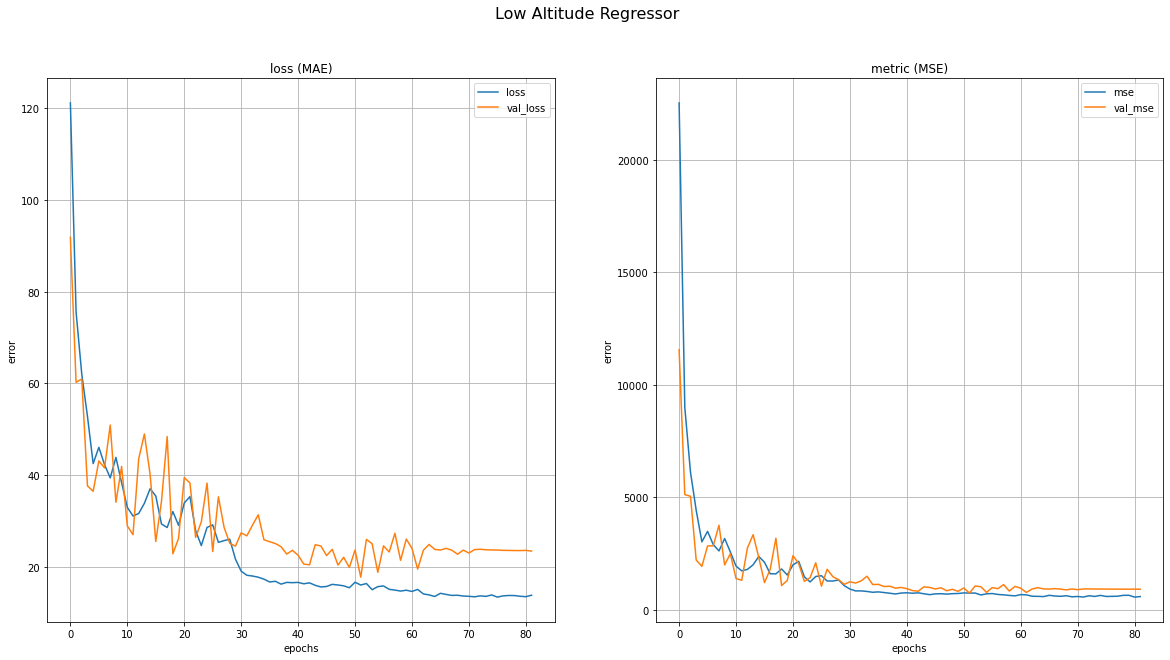

In [24]:
plot_metrics(history, title="Low Altitude Regressor")

In [25]:
results = reg_low.evaluate(X_low_test, y_low_test)

12/12 [==============================] - 0s 6ms/step - loss: 22.8982 - mean_squared_error: 869.0827


### Regression on High Altitude


In [26]:
normalizer_high = Normalization(axis=-1)
normalizer_high.adapt(np.array(X_high_train))

2022-07-18 17:00:08.410255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 17:00:08.422304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [27]:
first_sample = np.array(X_high_train[:1])

with np.printoptions(precision=2, suppress=True):
    print("X_low_train first sample:", np.sort(first_sample))
    print("X_low train first sample normalized:", np.sort(normalizer_high(first_sample).numpy()))

X_low_train first sample: [[ 11  15  40  50 144]]
X_low train first sample normalized: [[-1.01 -0.5   0.61  0.96  1.17]]


In [29]:
reg_high = create_regressor(normalizer_high)
reg_high.summary()
reg_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mae", metrics=metrics)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 256)               1536      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,572
Trainable params: 34,561
Non-trainable params: 11
_________________________________________________

In [30]:
history = reg_high.fit(X_high_train, y_high_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
 9/50 [====>.........................] - ETA: 0s - loss: 133.6295 - mean_squared_error: 13123.0020

2022-07-18 17:00:51.776038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 10ms/step - loss: 111.0856 - mean_squared_error: 16020.0752 - val_loss: 81.5009 - val_mean_squared_error: 11284.8311 - lr: 0.1000
Epoch 2/1000
 9/50 [====>.........................] - ETA: 0s - loss: 83.9182 - mean_squared_error: 12132.8496 

2022-07-18 17:00:52.286082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 0s 8ms/step - loss: 76.9927 - mean_squared_error: 9795.9365 - val_loss: 74.2934 - val_mean_squared_error: 7981.4575 - lr: 0.1000
Epoch 3/1000
50/50 [==============================] - 0s 7ms/step - loss: 68.9342 - mean_squared_error: 7826.0200 - val_loss: 55.0380 - val_mean_squared_error: 4738.4922 - lr: 0.1000
Epoch 4/1000
50/50 [==============================] - 0s 7ms/step - loss: 56.5137 - mean_squared_error: 5895.4683 - val_loss: 63.3002 - val_mean_squared_error: 7544.0400 - lr: 0.1000
Epoch 5/1000
50/50 [==============================] - 0s 7ms/step - loss: 59.9827 - mean_squared_error: 6576.3960 - val_loss: 48.7393 - val_mean_squared_error: 4018.8359 - lr: 0.1000
Epoch 6/1000
50/50 [==============================] - 0s 8ms/step - loss: 48.7670 - mean_squared_error: 4871.5464 - val_loss: 38.3233 - val_mean_squared_error: 3364.0120 - lr: 0.1000
Epoch 7/1000
50/50 [==============================] - 1s 11ms/step - loss: 62.5150 - mean_squared_

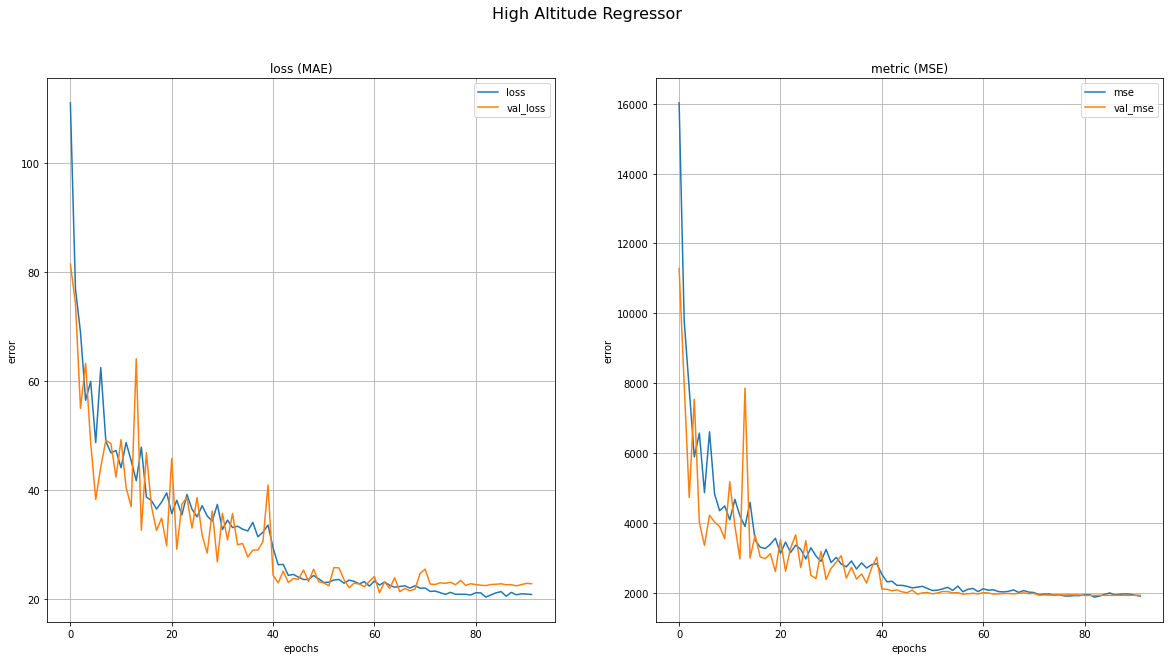

In [31]:
plot_metrics(history, title="High Altitude Regressor")

In [32]:
results = reg_high.evaluate(X_high_test, y_high_test)

16/16 [==============================] - 0s 9ms/step - loss: 23.3158 - mean_squared_error: 2043.0847


## Timeseries Forecasting


✅ Split dataset in multivariate time series

✅ Trained LSTM

Forecast LSTM predictions untill 20:00
- Manually create time, azimuth and elevation vectors for hour range 14:40 - 20:00
- Use LSTM to predict power given the manually created features


In [ ]:
high_altitude.plot(figsize=(30, 10), title="High altitude", marker="x", linestyle="None")

### Utility functions

In [33]:
def normalize(df):
    df_std = df.copy()
    for column in df_std.columns[:-1]:
        df_std[column] = df_std[column] / df_std[column].max()
    return df_std

In [46]:
def plot_predictions(model, X, y):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": y})
    df.plot(figsize=(20, 10), marker="x", linestyle="--", xlabel="samples", ylabel="power", title="Predictions vs Actuals")
    return df

In [35]:
def df_to_X_y(df, window_size=5, horizon=1):
    df_as_np = df.to_numpy()
    X = []
    y = []
    if (len(df_as_np) - window_size - horizon) == 0:
        row = [r for r in df_as_np[:window_size, :]]
        X.append(row)
        label = df_as_np[horizon + window_size][-1]
        y.append(label)
        return np.array(X), np.array(y)
    for i in range(len(df_as_np) - window_size - horizon):
        row = [r for r in df_as_np[i : i + window_size, :]]
        X.append(row)
        label = df_as_np[i + horizon + window_size][-1]
        y.append(label)
    return np.array(X), np.array(y)

In [49]:
def df_to_X(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    if (len(df_as_np) - window_size) == 0:
        row = [r for r in df_as_np[:window_size, :]]
        X.append(row)
        return np.array(X)

    for i in range(len(df_as_np) - window_size - 1):
        row = [r for r in df_as_np[i : i + window_size, :]]
        X.append(row)
    return np.array(X)

## Forecast on high_altitude_norm_correct


### Generate times, elevation and azimuth vectors to predict power for the rest of the day


In [36]:
future_azimuth = []
future_elevation = []
current_time = high_altitude.index.values
current_time_last = current_time[-1]

# create a vector of dates from current_time_last to the hours 20:00 of the same day with a frequency of 5 seconds
future_time = pd.date_range(current_time_last, end="2016-11-23T20:00:00", freq="5S")

#extending the azimuth vector
curr_azimuth = high_altitude["azimuth"]
period = np.unique(curr_azimuth[2361:2434])
to_repeat = []
for elem in period:
    to_repeat += [elem] * 7

future_azimuth = np.tile(to_repeat, len(future_time) // len(to_repeat))

future_df = pd.DataFrame({"azimuth": future_azimuth})

future_time = future_time[: len(future_azimuth)]

len(future_time)
future_df.index = future_time

#extending the elevation vector
curr_elevation = high_altitude["elevation"]
elevation_period = [0, 15, 30, 45, 60, 75, 90]
future_elevation = elevation_period * (future_df.shape[0] // len(elevation_period))
future_df["elevation"] = future_elevation

#adding time as features in the dataset
future_df["hour"] = future_df.index.hour
future_df["minute"] = future_df.index.minute
future_df["second"] = future_df.index.second
future_df = future_df[["hour", "minute", "second", "azimuth", "elevation"]]

print(future_df)

                     hour  minute  second  azimuth  elevation
2016-11-23 14:46:41    14      46      41        0          0
2016-11-23 14:46:46    14      46      46        0         15
2016-11-23 14:46:51    14      46      51        0         30
2016-11-23 14:46:56    14      46      56        0         45
2016-11-23 14:47:01    14      47       1        0         60
...                   ...     ...     ...      ...        ...
2016-11-23 19:54:16    19      54      16      180         30
2016-11-23 19:54:21    19      54      21      180         45
2016-11-23 19:54:26    19      54      26      180         60
2016-11-23 19:54:31    19      54      31      180         75
2016-11-23 19:54:36    19      54      36      180         90

[3696 rows x 5 columns]


### Normalizing high_altitude based on full day time

In [37]:
final_df = pd.concat([high_altitude, future_df], axis=0)
print(final_df)
final_df_norm = normalize(final_df)
print(final_df_norm)

                     hour  minute  second  azimuth  elevation  power
2016-11-23 09:45:05     9      45       5        0          0   32.0
2016-11-23 09:45:12     9      45      12        0         30   34.0
2016-11-23 09:45:15     9      45      15        0         45   35.0
2016-11-23 09:45:18     9      45      18        0         60   51.0
2016-11-23 09:45:21     9      45      21        0         75   76.0
...                   ...     ...     ...      ...        ...    ...
2016-11-23 19:54:16    19      54      16      180         30    NaN
2016-11-23 19:54:21    19      54      21      180         45    NaN
2016-11-23 19:54:26    19      54      26      180         60    NaN
2016-11-23 19:54:31    19      54      31      180         75    NaN
2016-11-23 19:54:36    19      54      36      180         90    NaN

[6155 rows x 6 columns]
                         hour    minute    second  azimuth  elevation  power
2016-11-23 09:45:05  0.473684  0.762712  0.084746      0.0   0.000000 

In [39]:
high_altitude_norm_correct = final_df_norm.iloc[: high_altitude.shape[0], :]
#high_altitude_norm_correct.to_csv("high_altitude_norm_correct.csv")
print(high_altitude_norm_correct)

                         hour    minute    second  azimuth  elevation  power
2016-11-23 09:45:05  0.473684  0.762712  0.084746      0.0   0.000000   32.0
2016-11-23 09:45:12  0.473684  0.762712  0.203390      0.0   0.333333   34.0
2016-11-23 09:45:15  0.473684  0.762712  0.254237      0.0   0.500000   35.0
2016-11-23 09:45:18  0.473684  0.762712  0.305085      0.0   0.666667   51.0
2016-11-23 09:45:21  0.473684  0.762712  0.355932      0.0   0.833333   76.0
...                       ...       ...       ...      ...        ...    ...
2016-11-23 14:46:27  0.736842  0.779661  0.457627      0.2   1.000000  172.0
2016-11-23 14:46:30  0.736842  0.779661  0.508475      0.3   0.000000  108.0
2016-11-23 14:46:35  0.736842  0.779661  0.593220      0.3   0.166667  159.0
2016-11-23 14:46:38  0.736842  0.779661  0.644068      0.3   0.333333  213.0
2016-11-23 14:46:41  0.736842  0.779661  0.694915      0.3   0.500000  105.0

[2459 rows x 6 columns]


## Train the forecasting LSTM network

### Train test split

In [40]:
X, y = df_to_X_y(high_altitude_norm_correct)

df_len = high_altitude_norm_correct.shape[0]
train = int(df_len * 0.7)
val = int(df_len * 0.9)
X_train, y_train = X[:train], y[:train]
X_val, y_val = X[train:val], y[train:val]
X_test, y_test = X[val:], y[val:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1721, 5, 6), (1721,), (492, 5, 6), (492,), (240, 5, 6), (240,))

## Model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((5, 6)))
model.add(LSTM(64))
model.add(Dense(8, "relu"))
model.add(Dense(1, "linear"))

model.summary()

model.compile(loss="mae", optimizer=Adam())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [42]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-10, verbose=1), tf.keras.callbacks.EarlyStopping(patience=50)]

In [43]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=callbacks)

Epoch 1/300


2022-07-18 17:02:20.611802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 17:02:20.827231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 17:02:20.941468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 16ms/step - loss: 227.9676 - val_loss: 198.7993 - lr: 0.0010
Epoch 2/300
 1/54 [..............................] - ETA: 0s - loss: 229.2499

2022-07-18 17:02:21.716279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 17:02:21.780231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 12ms/step - loss: 224.4910 - val_loss: 193.6262 - lr: 0.0010
Epoch 3/300
54/54 [==============================] - 1s 10ms/step - loss: 217.3019 - val_loss: 184.9943 - lr: 0.0010
Epoch 4/300
54/54 [==============================] - 1s 11ms/step - loss: 207.6866 - val_loss: 173.7094 - lr: 0.0010
Epoch 5/300
54/54 [==============================] - 1s 12ms/step - loss: 195.1881 - val_loss: 160.4427 - lr: 0.0010
Epoch 6/300
54/54 [==============================] - 1s 10ms/step - loss: 181.4970 - val_loss: 146.2631 - lr: 0.0010
Epoch 7/300
54/54 [==============================] - 1s 10ms/step - loss: 167.2734 - val_loss: 131.6340 - lr: 0.0010
Epoch 8/300
54/54 [==============================] - 1s 10ms/step - loss: 153.3570 - val_loss: 117.5091 - lr: 0.0010
Epoch 9/300
54/54 [==============================] - 1s 10ms/step - loss: 140.4557 - val_loss: 105.5887 - lr: 0.0010
Epoch 10/300
54/54 [==============================] - 1s 10ms/step - loss: 1

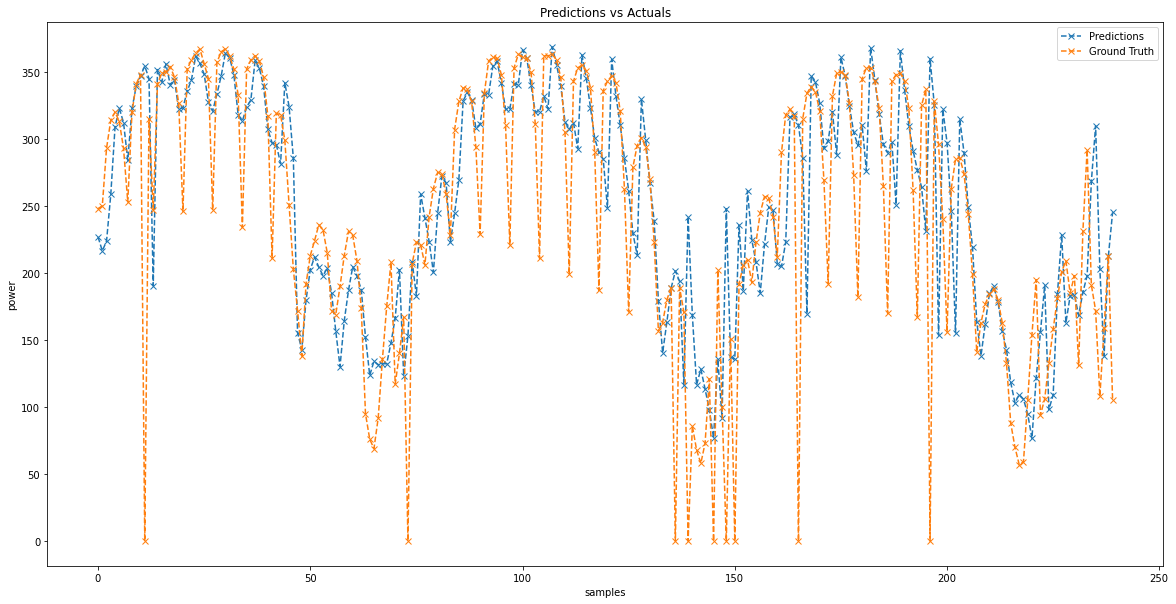

In [47]:
test_predictions = plot_predictions(model, X_test, y_test)

In [48]:
print(test_predictions["Predictions"].mean())
print(test_predictions["Ground Truth"].mean())
print(test_predictions["Predictions"].mean() - test_predictions["Ground Truth"].mean())

254.1452
245.27083333333334
8.874369303385407


In [ ]:
#model.save("./forecasting_model/forecast_lstm_norm.h5")

In [50]:
last_ground_truth = high_altitude_norm_correct.iloc[-5:, :]
last_ground_truth

,hour,minute,second,azimuth,elevation,power
2016-11-23 14:46:27,0.736842,0.779661,0.457627,0.2,1.000000,172.0
2016-11-23 14:46:30,0.736842,0.779661,0.508475,0.3,0.000000,108.0
2016-11-23 14:46:35,0.736842,0.779661,0.593220,0.3,0.166667,159.0
2016-11-23 14:46:38,0.736842,0.779661,0.644068,0.3,0.333333,213.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.3,0.500000,105.0


### Testing the model for forecasting

In [51]:
trial_x = df_to_X(last_ground_truth)

In [52]:
trial_x

array([[[7.36842105e-01, 7.79661017e-01, 4.57627119e-01, 2.00000000e-01,
         1.00000000e+00, 1.72000000e+02],
        [7.36842105e-01, 7.79661017e-01, 5.08474576e-01, 3.00000000e-01,
         0.00000000e+00, 1.08000000e+02],
        [7.36842105e-01, 7.79661017e-01, 5.93220339e-01, 3.00000000e-01,
         1.66666667e-01, 1.59000000e+02],
        [7.36842105e-01, 7.79661017e-01, 6.44067797e-01, 3.00000000e-01,
         3.33333333e-01, 2.13000000e+02],
        [7.36842105e-01, 7.79661017e-01, 6.94915254e-01, 3.00000000e-01,
         5.00000000e-01, 1.05000000e+02]]])

### Assembling the dataframe on which to forecast power values

In [54]:
model = tf.keras.models.load_model("./forecasting_model/forecast_lstm_norm_correct.h5")

In [55]:
final_df = pd.concat([last_ground_truth, final_df_norm[high_altitude.shape[0] :]], axis=0)
final_df.head(20)

,hour,minute,second,azimuth,elevation,power
2016-11-23 14:46:27,0.736842,0.779661,0.457627,0.2,1.000000,172.0
2016-11-23 14:46:30,0.736842,0.779661,0.508475,0.3,0.000000,108.0
2016-11-23 14:46:35,0.736842,0.779661,0.593220,0.3,0.166667,159.0
2016-11-23 14:46:38,0.736842,0.779661,0.644068,0.3,0.333333,213.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.3,0.500000,105.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.0,0.000000,NaN
2016-11-23 14:46:46,0.736842,0.779661,0.779661,0.0,0.166667,NaN
2016-11-23 14:46:51,0.736842,0.779661,0.864407,0.0,0.333333,NaN
2016-11-23 14:46:56,0.736842,0.779661,0.949153,0.0,0.500000,NaN
2016-11-23 14:47:01,0.736842,0.796610,0.016949,0.0,0.666667,NaN


In [ ]:
#final_df.to_csv("final_df_for_forecasting.csv")

In [56]:
final_df = pd.read_csv("final_df_for_forecasting.csv", index_col=0)
final_df

,hour,minute,second,azimuth,elevation,power
2016-11-23 14:46:27,0.736842,0.779661,0.457627,0.2,1.000000,172.0
2016-11-23 14:46:30,0.736842,0.779661,0.508475,0.3,0.000000,108.0
2016-11-23 14:46:35,0.736842,0.779661,0.593220,0.3,0.166667,159.0
2016-11-23 14:46:38,0.736842,0.779661,0.644068,0.3,0.333333,213.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.3,0.500000,105.0
...,...,...,...,...,...,...
2016-11-23 19:54:16,1.000000,0.915254,0.271186,1.0,0.333333,NaN
2016-11-23 19:54:21,1.000000,0.915254,0.355932,1.0,0.500000,NaN
2016-11-23 19:54:26,1.000000,0.915254,0.440678,1.0,0.666667,NaN
2016-11-23 19:54:31,1.000000,0.915254,0.525424,1.0,0.833333,NaN


### Forecasting power values

In [57]:
def forecast(df, model, window_size=5):
    forecasted_df = df.copy()
    for i in range(len(forecasted_df) - window_size):
        window = np.expand_dims(forecasted_df.iloc[i : i + window_size, :].to_numpy(), axis=0)
        # print(window)
        pred = int(model.predict(window)[0][0])
        forecasted_df.iat[i + window_size, 5] = pred
    return forecasted_df

In [61]:
forecasted_df = forecast(final_df, model)
forecasted_df

,hour,minute,second,azimuth,elevation,power
2016-11-23 14:46:27,0.736842,0.779661,0.457627,0.2,1.000000,172.0
2016-11-23 14:46:30,0.736842,0.779661,0.508475,0.3,0.000000,108.0
2016-11-23 14:46:35,0.736842,0.779661,0.593220,0.3,0.166667,159.0
2016-11-23 14:46:38,0.736842,0.779661,0.644068,0.3,0.333333,213.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.3,0.500000,105.0
...,...,...,...,...,...,...
2016-11-23 19:54:16,1.000000,0.915254,0.271186,1.0,0.333333,222.0
2016-11-23 19:54:21,1.000000,0.915254,0.355932,1.0,0.500000,291.0
2016-11-23 19:54:26,1.000000,0.915254,0.440678,1.0,0.666667,300.0
2016-11-23 19:54:31,1.000000,0.915254,0.525424,1.0,0.833333,272.0


<AxesSubplot:>

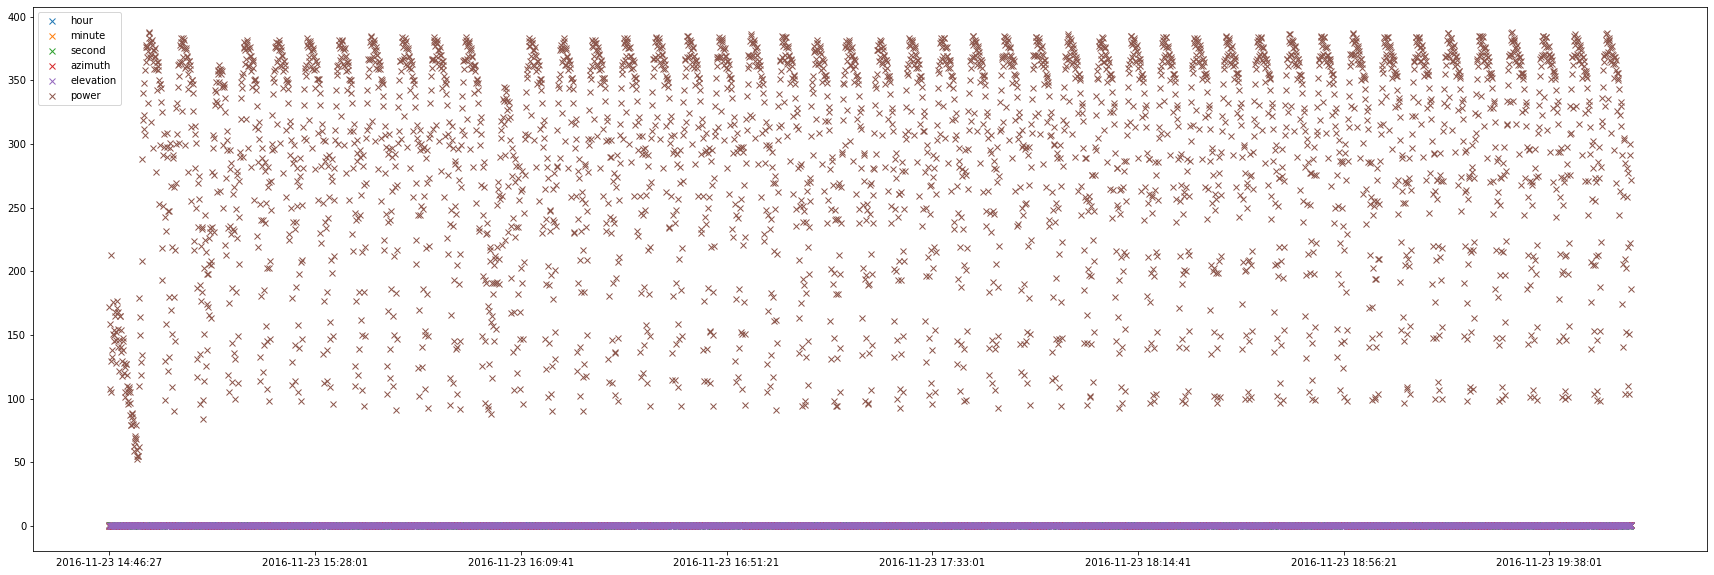

In [62]:
forecasted_df.plot(figsize=(30, 10), marker="x", linewidth=0.5, linestyle="None")

### Assembling the final dataframe containing the original values and the forecasted values for the rest of the day

In [63]:
high_altitude_whole_day = pd.concat([high_altitude_norm_correct, forecasted_df], axis=0)
#high_altitude_whole_day.to_csv("datasets/high_altitude_whole_day.csv")
high_altitude_whole_day

,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,0.473684,0.762712,0.084746,0.0,0.000000,32.0
2016-11-23 09:45:12,0.473684,0.762712,0.203390,0.0,0.333333,34.0
2016-11-23 09:45:15,0.473684,0.762712,0.254237,0.0,0.500000,35.0
2016-11-23 09:45:18,0.473684,0.762712,0.305085,0.0,0.666667,51.0
2016-11-23 09:45:21,0.473684,0.762712,0.355932,0.0,0.833333,76.0
...,...,...,...,...,...,...
2016-11-23 19:54:16,1.000000,0.915254,0.271186,1.0,0.333333,222.0
2016-11-23 19:54:21,1.000000,0.915254,0.355932,1.0,0.500000,291.0
2016-11-23 19:54:26,1.000000,0.915254,0.440678,1.0,0.666667,300.0
2016-11-23 19:54:31,1.000000,0.915254,0.525424,1.0,0.833333,272.0


<AxesSubplot:>

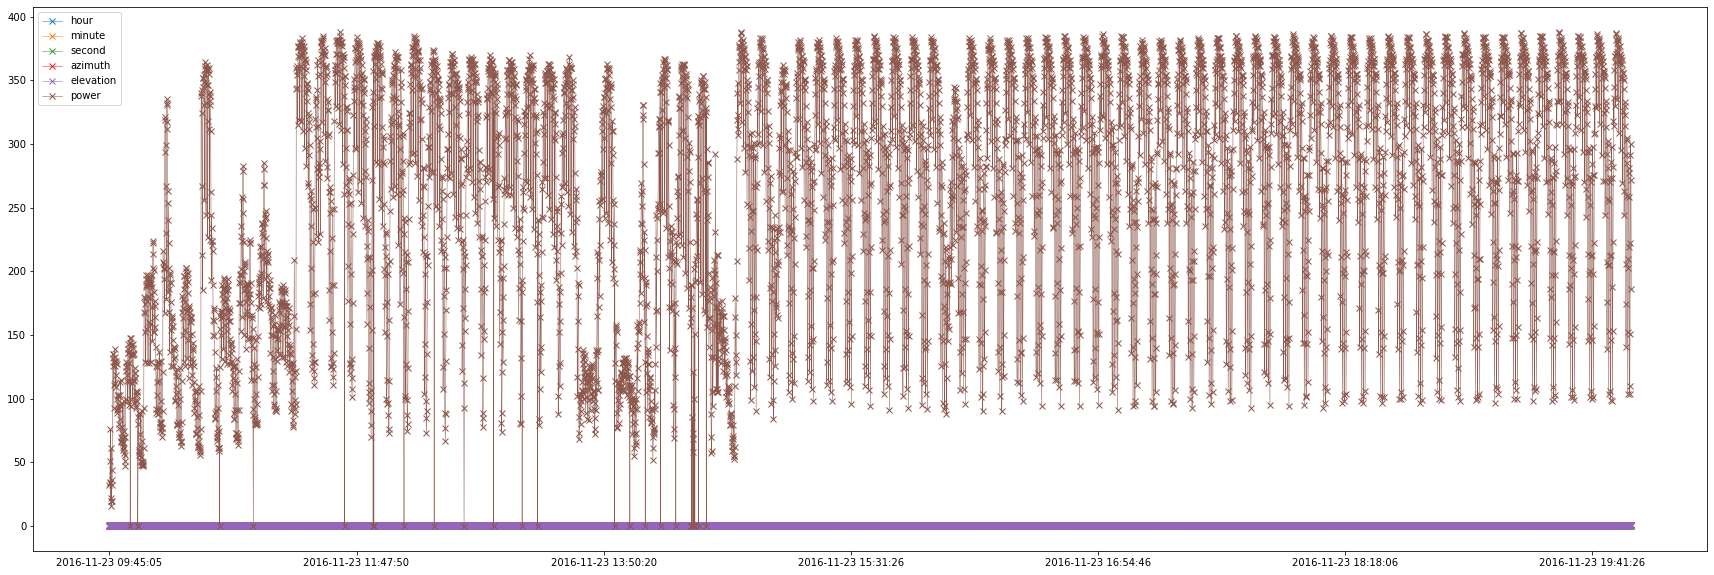

In [64]:
high_altitude_whole_day.plot(figsize=(30, 10), marker = 'x', linewidth=0.5)

To Do:

- calcolare il power generato in un giorno a partire da high_altitude_whole_day: usando la media?, la somma?
- trovare le dimensioni di un pannello solare
- trovare il fabbisogno energetico della carinzia
- misurare montagne carinzia su google earth (o solo monte Dobratsch)
- dividere area montagne per area pannello -> si ottiene quanti pannelli entrano sulle montagne
- calcolare il power generato in un giorno dal numero di pannelli che entrano sulle montagne
- verificare che sia sufficiente per soddisfare il fabbisogno della Carinzia (o della sola Klagenfurt)

- idea: fare una funzione che prende in input le dimensioni di un pannello, l'area disponibile, il power generato da un pannello e da


In [71]:
whole_day_power = high_altitude_whole_day["power"].sum()
print(f'The power produced by 1 solar panel for the whole day is: {whole_day_power * 1e-6} kW')

The power produced by 1 solar panel for the whole day is: 1.62313 kW
